In [63]:
%matplotlib inline
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import transforms, datasets, models

In [43]:
np.random.seed(0)
cache_dir = expanduser(join('~', '.torch'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [88]:
INPUT_SIZE = 224
NUM_CLASSES = 120
BATCH_SIZE = 20
data_dir = 'dataset'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))

120 21513


In [91]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])

train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

train_data = datasets.ImageFolder(train_dir, transform=ds_trans)
valid_data = datasets.ImageFolder(valid_dir, transform=ds_trans)
test_data = datasets.ImageFolder(test_dir, transform=ds_trans)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [75]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([20, 3, 224, 224]) torch.Size([20])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

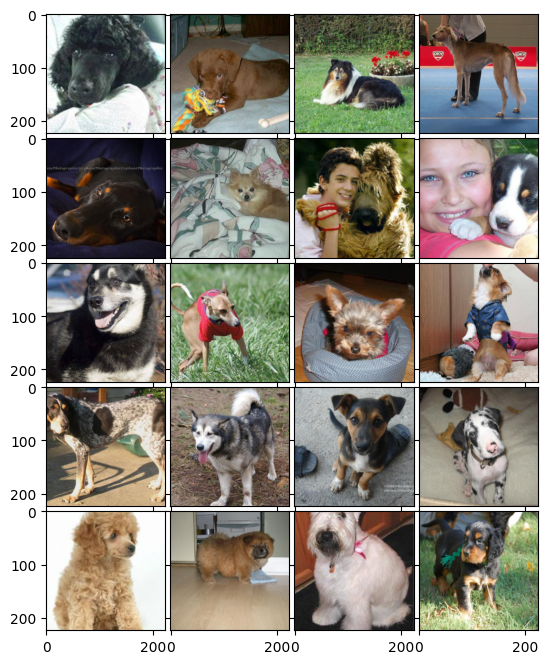

In [93]:
img, label = next(iter(train_loader))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(64, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 4), axes_pad=0.05)    
for i in range(len(grid)):
    ax = grid[i]
    imshow(ax, img[i])

In [94]:
use_gpu = torch.cuda.is_available()
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(train_loader))
if use_gpu:
    resnet = resnet.cuda()
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())   
else:
    inputs, labels = Variable(inputs), Variable(labels)
outputs = resnet(inputs)
outputs.size()

C:\Users\Kamil\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Kamil\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([20, 1000])

In [101]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()  # Zmiana na loss.item()
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [102]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [103]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
if use_gpu:
    resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_loader, 'valid':valid_loader}

In [104]:
start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=2)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [0/1] train loss: 0.0653 acc: 0.6635 valid loss: 0.0305 acc: 0.8249
Epoch [1/1] train loss: 0.0303 acc: 0.8153 valid loss: 0.0271 acc: 0.8312
Best val Acc: 0.831234
Training time:  76.170123 minutes


In [ ]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, '{}/{}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return
            
            
visualize_model(dloaders, resnet)